In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
cudnn.benchmark = True
plt.ion()   # interactive mode

# Data transform

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_Resize/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize data

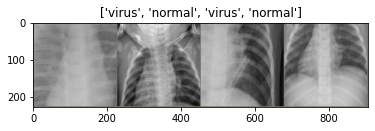

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Visualize model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Train model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, save_log=False):

    history = {
        'all_epoch_info': []
    }
    train = {

    }
    val = {

    }

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train = {
                    'loss': epoch_loss,
                    'acc': epoch_acc.item()
                }
            if phase == 'val':
                val = {
                    'loss': epoch_loss,
                    'acc': epoch_acc.item()
                }

            # deep copy the model
            if phase=='val':
                scheduler.step(epoch_loss)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), '/content/drive/MyDrive/COURSES/CS331/FinalProject/VGG16.pt')
        
        history['all_epoch_info'].append({
            'epoch': epoch,
            'info': { 
                'train': train,
                'val': val
            }
        })
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model if not save_log else model, history

In [ ]:
model_ft = models.vgg16(pretrained=True)
cnt = 0
for param in model_ft.parameters():
    if cnt < 32 * 3 // 4:
        param.requires_grad = False
    else:
        break
    cnt += 1
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = ReduceLROnPlateau(optimizer_ft, 'min', factor=0.1, patience=3, min_lr=1e-6, verbose=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, scheduler=scheduler, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.3748 Acc: 0.5426
val Loss: 0.8426 Acc: 0.6616

Epoch 2/50
----------
train Loss: 0.9629 Acc: 0.6153
val Loss: 0.7908 Acc: 0.6511

Epoch 3/50
----------
train Loss: 0.8764 Acc: 0.6332
val Loss: 0.6523 Acc: 0.7102

Epoch 4/50
----------
train Loss: 0.8819 Acc: 0.6349
val Loss: 0.7061 Acc: 0.6969

Epoch 5/50
----------
train Loss: 0.8405 Acc: 0.6361
val Loss: 0.7000 Acc: 0.6969

Epoch 6/50
----------
train Loss: 0.8788 Acc: 0.6396
val Loss: 0.8041 Acc: 0.6511

Epoch 7/50
----------
train Loss: 0.8727 Acc: 0.6406
val Loss: 0.7163 Acc: 0.6988
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.

Epoch 8/50
----------
train Loss: 0.8216 Acc: 0.6423
val Loss: 0.6649 Acc: 0.7083

Epoch 9/50
----------
train Loss: 0.7866 Acc: 0.6482
val Loss: 0.6490 Acc: 0.7169

Epoch 10/50
----------
train Loss: 0.7556 Acc: 0.6632
val Loss: 0.6393 Acc: 0.7188

Epoch 11/50
----------
train Loss: 0.7636 Acc: 0.6566
val Loss: 0.6285 Acc: 0.7178

Epoch 12/50
----------


# Plot results

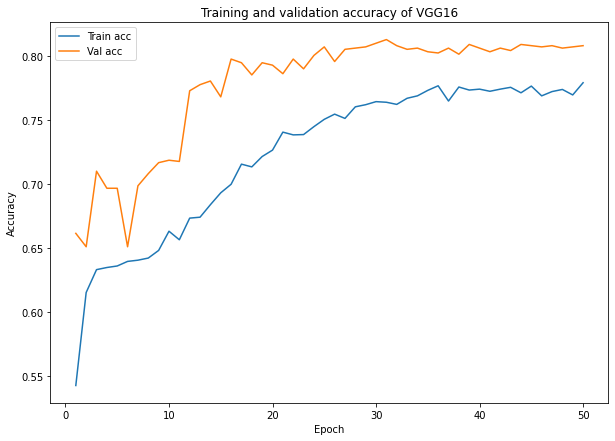

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

epochs = [x + 1 for x in range(50)]

train_acc, val_acc = [], []
for epoch in epochs:
    train_acc.append(history['all_epoch_info'][epoch - 1]['info']['train']['acc'])
    val_acc.append(history['all_epoch_info'][epoch - 1]['info']['val']['acc'])

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_acc, label='Train acc')
plt.plot(epochs, val_acc, label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy of VGG16')
plt.legend()
plt.plot()
plt.show()
plt.savefig('train-vgg.pdf')